In [1]:
import cv2

import numpy as np

In [2]:
video_path = r'C:\Users\es25591\Workspace\360dataset\content\saliency\coaster_saliency.mp4'
cap = cv2.VideoCapture(video_path)

# Check if video opened successfully
if cap.isOpened():
    print("Video loaded successfully")
    print(f"Frame count: {int(cap.get(cv2.CAP_PROP_FRAME_COUNT))}")
    print(f"FPS: {cap.get(cv2.CAP_PROP_FPS)}")
    print(f"Frame size: {int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))} x {int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))}")
else:
    print("Error: Could not open video")

Video loaded successfully
Frame count: 1800
FPS: 30.0
Frame size: 3840 x 1920


In [ ]:
import random


count = 0
attention_frames = []
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

while True:
    ret_f, f = cap.read()
    if not ret_f:
        break
    gray = cv2.cvtColor(f, cv2.COLOR_BGR2GRAY)
    
    attention_frames.append(gray)
    
    # print(f"Frame {count}: shape={gray.shape}, dtype={gray.dtype}")
    count += 1

Frame 0: shape=(1920, 3840), dtype=uint8
Frame 1: shape=(1920, 3840), dtype=uint8
Frame 2: shape=(1920, 3840), dtype=uint8
Frame 3: shape=(1920, 3840), dtype=uint8
Frame 4: shape=(1920, 3840), dtype=uint8
Frame 5: shape=(1920, 3840), dtype=uint8
Frame 6: shape=(1920, 3840), dtype=uint8
Frame 7: shape=(1920, 3840), dtype=uint8
Frame 8: shape=(1920, 3840), dtype=uint8
Frame 9: shape=(1920, 3840), dtype=uint8
Frame 10: shape=(1920, 3840), dtype=uint8
Frame 11: shape=(1920, 3840), dtype=uint8
Frame 12: shape=(1920, 3840), dtype=uint8
Frame 13: shape=(1920, 3840), dtype=uint8
Frame 14: shape=(1920, 3840), dtype=uint8
Frame 15: shape=(1920, 3840), dtype=uint8
Frame 16: shape=(1920, 3840), dtype=uint8
Frame 17: shape=(1920, 3840), dtype=uint8
Frame 18: shape=(1920, 3840), dtype=uint8
Frame 19: shape=(1920, 3840), dtype=uint8
Frame 20: shape=(1920, 3840), dtype=uint8
Frame 21: shape=(1920, 3840), dtype=uint8
Frame 22: shape=(1920, 3840), dtype=uint8
Frame 23: shape=(1920, 3840), dtype=uint8
Fr

In [4]:
n = 4
def split_into_tiles(arr, n):
    h, w = arr.shape
    tile_h, tile_w = h // n, w // n
    tiles = []
    for i in range(n):
        for j in range(n):
            y0, y1 = i * tile_h, (i + 1) * tile_h
            x0, x1 = j * tile_w, (j + 1) * tile_w
            tiles.append(arr[y0:y1, x0:x1])
    return tiles

In [5]:
bitrate_levels = [
    5800,  # 1920x1080
    7500,  # 2560x1440
    12000, # 3840x2160
    17000, # 3840x2160
    22000, # 5120x2880
    25000, # 7680x4320
    30000  # 7680x4320
] # in kbps

class VideoTile:
    def __init__(
        self, 
        frames,
        tiles_per_side,
        tiles_levels,
        attention_probabilities
    ):
        self.total_frames = len(frames)
        self.frames = frames
        self.tiles_per_side = tiles_per_side
        self.num_tiles = tiles_per_side * tiles_per_side
    
        self.frames_tiles = np.array([
            split_into_tiles(frame, tiles_per_side) for frame in frames
        ])

        self.tiles_sizes = np.array([
            br / self.num_tiles for br in bitrate_levels
        ])

        self.attention_probabilities = attention_probabilities
        
video_config = VideoTile(
    frames=attention_frames,
    tiles_per_side=n,
    tiles_levels=bitrate_levels,
    attention_probabilities=None
)

In [6]:
total_att_per_frame = []
for i, frame in enumerate(attention_frames):    
    total_attention = np.sum(frame)
    total_att_per_frame.append(total_attention)

total_att_per_frame = np.array(total_att_per_frame)

In [7]:
total_att_per_tile = []
for i in range(video_config.total_frames):
    total_att_per_tile.append([])
    for j, frame_tiles in enumerate(video_config.frames_tiles[i]):        
        total_tile = np.sum(frame_tiles)
        total_att_per_tile[i].append(total_tile)
        
total_att_per_tile = np.array(total_att_per_tile)

In [8]:
attention_probabilities = []
for i in range(video_config.total_frames):
    frame_att_total = total_att_per_frame[i]
    tile_probs = []
    for j, frame_tiles in enumerate(video_config.frames_tiles[i]):
        tile_att_total = total_att_per_tile[i][j]

        tile_prob = tile_att_total / frame_att_total
        tile_probs.append(tile_prob)

    attention_probabilities.append(tile_probs)

In [9]:
video_config.attention_probabilities = attention_probabilities

In [10]:
import collections

class Cache:
    def __init__(
        self, 
        max_size=1000,
        video_config=None,
    ):
        self.cur_size = 0
        self.max_size = max_size

        self.objects = collections.OrderedDict()

        self.hit_count = 0
        self.miss_count = 0

    def get(self, key, video):
        
        if key not in self.objects:
            self.miss_count += 1
        else:
            self.hit_count += 1
        
        value = self.objects.pop(key)
        self.objects[key] = value

        return value
        
        
    def put(self, key, value):
        self.objects[key] = value
        self.cur_size += len(value)
        
        while self.cur_size > self.max_size:
            old_key, old_value = self.objects.popitem(last=False)
            self.cur_size -= len(old_value)

    def capacity(self):
        return self.max_size

In [11]:
class Edge:
    """
    Edge cache service using an attention-driven strategy.

    Usage examples (given notebook variables):
      edge = Edge(tiles_info=tiles_info, attention_map=attention_2d, tiles_per_side=n)
      edge.allocate_cache(bitrate_budget=50, layers=('base','enhancement'))
      edge.get_cached_tiles()
      edge.serve_request(tile_id=3, layer='enhancement')
    """
    def __init__(
        self, 
        tiles_info, 
        tiles_attention=None, 
        attention_map=None, 
        tiles_per_side=None
    ):
        self.video_config = video_config
        self.cache = Cache(max_size=10000)

    def _scores_from_tiles(self, tiles):
        """
        Compute a scalar attention score per tile: mean of tile values.
        Accepts list of numpy arrays (tile maps) or list of scalars.
        Returns dict tile_id -> score aligned with tiles_info order.
        """
        scores = {}
        # if tiles length equals num_tiles assume same ordering as tiles_info
        if hasattr(tiles, "__len__") and len(tiles) == self.num_tiles:
            for i, tid in enumerate(self.tile_ids):
                t = tiles[i]
                try:
                    scores[tid] = float(np.mean(t))
                except Exception:
                    # if tile already scalar-like
                    scores[tid] = float(t)
        else:
            # fallback - uniform
            for tid in self.tile_ids:
                scores[tid] = 1.0
        # normalize scores to avoid zero-value items
        vals = np.array(list(scores.values()), dtype=float)
        if vals.max() > 0:
            norm = vals / (vals.max())
            for i, tid in enumerate(self.tile_ids):
                scores[tid] = float(norm[i])
        return scores

    def _tile_params(self, tid):
        i = self.tile_ids.index(tid)
        return {
            'base_cost': int(self.tiles_info['base_layer_bitrate'][i]),
            'enh_cost': int(self.tiles_info['enhancement_layer_bitrate'][i]),
            'base_value': float(self.tiles_info['base_layer_distortion_reduction'][i]),
            'enh_value': float(self.tiles_info['enhancement_layer_distortion_reduction'][i]),
            'attention': float(self.attention_scores.get(tid, 1.0))
        }

    def allocate_cache(self, bitrate_budget, layers=('base', 'enhancement')):
        """
        Allocate cache under a bitrate_budget using greedy value-per-cost.
        layers: tuple containing any of 'base', 'enhancement' specifying which layers may be cached.
        Sets self.cached and returns allocation list of dicts.
        """
        items = []
        for tid in self.tile_ids:
            p = self._tile_params(tid)
            att = p['attention']
            if 'base' in layers and p['base_cost'] > 0:
                value = p['base_value'] * att
                items.append({'tile_id': tid, 'layer': 'base', 'cost': p['base_cost'], 'value': value})
            if 'enhancement' in layers and p['enh_cost'] > 0:
                value = p['enh_value'] * att
                items.append({'tile_id': tid, 'layer': 'enhancement', 'cost': p['enh_cost'], 'value': value})

        # guard: remove zero-cost or zero-value items
        items = [it for it in items if it['cost'] > 0 and it['value'] > 0]

        # sort by value per cost descending
        items.sort(key=lambda it: (it['value'] / it['cost']), reverse=True)

        # reset cached
        self.cached = {tid: {'base': False, 'enhancement': False} for tid in self.tile_ids}
        allocation = []
        remaining = int(bitrate_budget)

        for it in items:
            if it['cost'] <= remaining:
                # don't double-cache same layer twice
                if not self.cached[it['tile_id']][it['layer']]:
                    self.cached[it['tile_id']][it['layer']] = True
                    allocation.append(it.copy())
                    remaining -= it['cost']

        self.last_allocation = allocation
        return allocation

    def get_cached_tiles(self):
        """
        Returns list of (tile_id, layers_cached) for tiles that have at least one layer cached.
        """
        out = []
        for tid, state in self.cached.items():
            layers = [k for k, v in state.items() if v]
            if layers:
                out.append({'tile_id': tid, 'layers': layers})
        return out

    def total_cached_bitrate(self):
        total = 0
        for tid, state in self.cached.items():
            p = self._tile_params(tid)
            if state['base']:
                total += p['base_cost']
            if state['enhancement']:
                total += p['enh_cost']
        return total

    def total_cached_value(self):
        total = 0.0
        for tid, state in self.cached.items():
            p = self._tile_params(tid)
            if state['base']:
                total += p['base_value'] * p['attention']
            if state['enhancement']:
                total += p['enh_value'] * p['attention']
        return total

    def serve_request(self, tile_id, layer):
        """
        Check if requested layer for tile is cached.
        layer: 'base' or 'enhancement'
        Returns True if cached, False otherwise.
        """
        if tile_id not in self.cached:
            return False
        return bool(self.cached[tile_id].get(layer, False))

    def update_attention(self, tiles_attention=None, attention_map=None, tiles_per_side=None):
        """
        Recompute attention scores from new data and clear previous allocation.
        """
        if tiles_attention is not None:
            self.attention_scores = self._scores_from_tiles(tiles_attention)
        elif attention_map is not None:
            if tiles_per_side is None:
                raise ValueError("tiles_per_side required when passing attention_map")
            tiles = split_into_tiles(attention_map, tiles_per_side)
            self.attention_scores = self._scores_from_tiles(tiles)
        else:
            return
        # clear cached allocation (caller should re-run allocate_cache)
        self.cached = {tid: {'base': False, 'enhancement': False} for tid in self.tile_ids}
        self.last_allocation = []

In [12]:
# Build per-tile bitrate info and create an Edge cache object
# Assumptions: base layer uses the smallest bitrate level, enhancement uses the largest.
# Each entry below is per-tile (bitrate in kbps).
num_tiles = video_config.num_tiles
tile_ids = list(range(num_tiles))
# per-tile cost derived from global bitrate levels divided equally across tiles
base_per_tile = bitrate_levels[0] / float(num_tiles)
enh_per_tile = bitrate_levels[-1] / float(num_tiles)
tiles_info = {
    'tile_id': tile_ids,
    'base_layer_bitrate': [int(base_per_tile)] * num_tiles,
    'enhancement_layer_bitrate': [int(enh_per_tile)] * num_tiles,
    # distortion reduction values are simple heuristics here (0..1 scale) - adjust as needed
    'base_layer_distortion_reduction': [0.5] * num_tiles,
    'enhancement_layer_distortion_reduction': [0.8] * num_tiles,
}
# Create Edge instance (uses tiles_info and optional attention).
edge = Edge(tiles_info=tiles_info, tiles_per_side=n)
# Example allocation using a sample bitrate budget (kbps) - tweak as needed
budget_kbps = 50000
allocation = edge.allocate_cache(bitrate_budget=budget_kbps, layers=('base','enhancement'))
print('Sample bitrate budget (kbps):', budget_kbps)
print('Number of tiles:', num_tiles)
print('Per-tile base bitrate (kbps):', int(base_per_tile))
print('Per-tile enhancement bitrate (kbps):', int(enh_per_tile))
for it in allocation[:20]:
    print(it)
print('Total cached value:', edge.total_cached_value())
print(edge.get_cached_tiles())

AttributeError: 'Edge' object has no attribute 'tile_ids'

Running random_walk(1000, 0)...


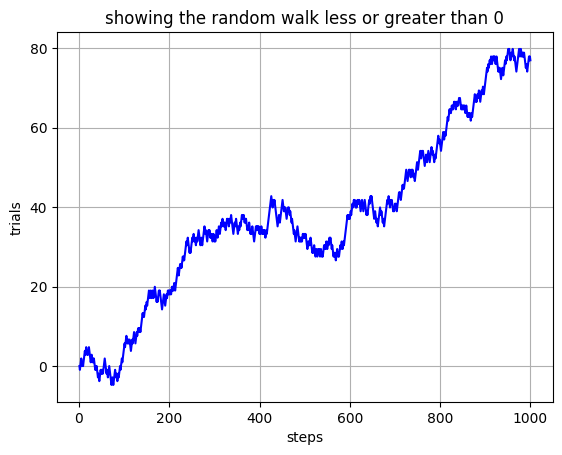

Plot window opened.
Final value in the vector: 76.95


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def random_walk(number_of_tries, center):
    """
    Performs a 1D random walk and plots the result.

    Equivalent to the MATLAB function:
    Input: x = random_walk(1000, 0)

    Output: a NumPy array x containing the data of the
    random walk with a starting point at 0. Additionally
    the result is plotted.
    """
    
    # Initialising values
    yv = np.random.rand(number_of_tries)  # Create a 1D array of random numbers
    
    # 'sum' is a built-in Python function, so we use a different name.
    current_position = center 
    
    # Initialize the output vector
    ver = np.zeros(number_of_tries) 
    ver[0] = center         # Python uses 0-based indexing
    
    # Loop from the second element (index 1) to the end
    # This corresponds to the MATLAB 'for i = 2:num'
    for i in range(1, number_of_tries):
        if yv[i] < 0.5:
            current_position += 1  # Use += for in-place addition
        else:
            current_position -= 1  # Use -= for in-place subtraction
        
        ver[i] = 0.95 * current_position

    # Plot result
    plt.figure(1)
    
    # MATLAB's '1:num' creates an array [1, 2, ..., num]
    # np.arange(1, num + 1) does the same in Python
    x_axis = np.arange(1, number_of_tries + 1) 
    
    plt.plot(x_axis, ver, color='blue') # Set color directly
    plt.grid(True)                      # 'grid on'
    plt.title('showing the random walk less or greater than 0')
    plt.ylabel('trials') # This was the label in the original MATLAB
    plt.xlabel('steps')  # Added an x-label for clarity
    
    plt.show() # Display the plot

    return ver

# --- Example of how to run the function ---
# This block ensures the code only runs when the script is executed directly
if __name__ == '__main__':
    print("Running random_walk(1000, 0)...")
    x = random_walk(1000, 0)
    print("Plot window opened.")
    print(f"Final value in the vector: {x[-1]}")